In [15]:
import numpy as np
import cv2 as cv
import scipy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 15)

img_dir = "images/"


def show_pics(plot_colum_size, plot_row_size, imgs, **kargs):
    for i in range(plot_colum_size * plot_row_size):
        plt.subplot(plot_row_size, plot_colum_size, i+1)
        img = imgs[i]
        d = len(img.shape)
        if d != 3:
            kargs['cmap'] = 'gray'
        plt.imshow(img, **kargs)
    plt.show()


def cv_show_pics(plot_colum_size, plot_row_size, imgs, **kargs):
    cv_imgs = []
    for img in imgs:
        cv_imgs.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    show_pics(plot_colum_size, plot_row_size, cv_imgs, **kargs)


def draw_box(box, frame):
    pts = cv.boxPoints(box)
    pts = np.int0(pts)
    frame = cv.polylines(frame, [pts], True, 255, 2)
    a, _, b, _ = pts
    cx = int((a[0] + b[0]) / 2)
    cy = int((a[1] + b[1]) / 2)
    frame = cv.circle(frame, (cx, cy), 10, (255, 0, 0), -1)
    return frame


def resize_greatest_ax(img, s):
    y, x = img.shape[:2]
    if x > y:
        r = s / x
        nx = s
        ny = y * r
    else:
        r = s / y
        nx = x * r
        ny = s
    return cv2.resize(img, (int(nx), int(ny)))


def feature_match(img, resize=True, mask=None):
    gray = img  # cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if resize:
        gray = resize_greatest_ax(gray, 512)

#     descriptor = cv2.ORB_create(400)
#     descriptor = cv2.xfeatures2d.SIFT_create(400)
    descriptor = cv2.xfeatures2d.SURF_create(400)
    (kps, features) = descriptor.detectAndCompute(gray, mask)
    return gray, kps, features

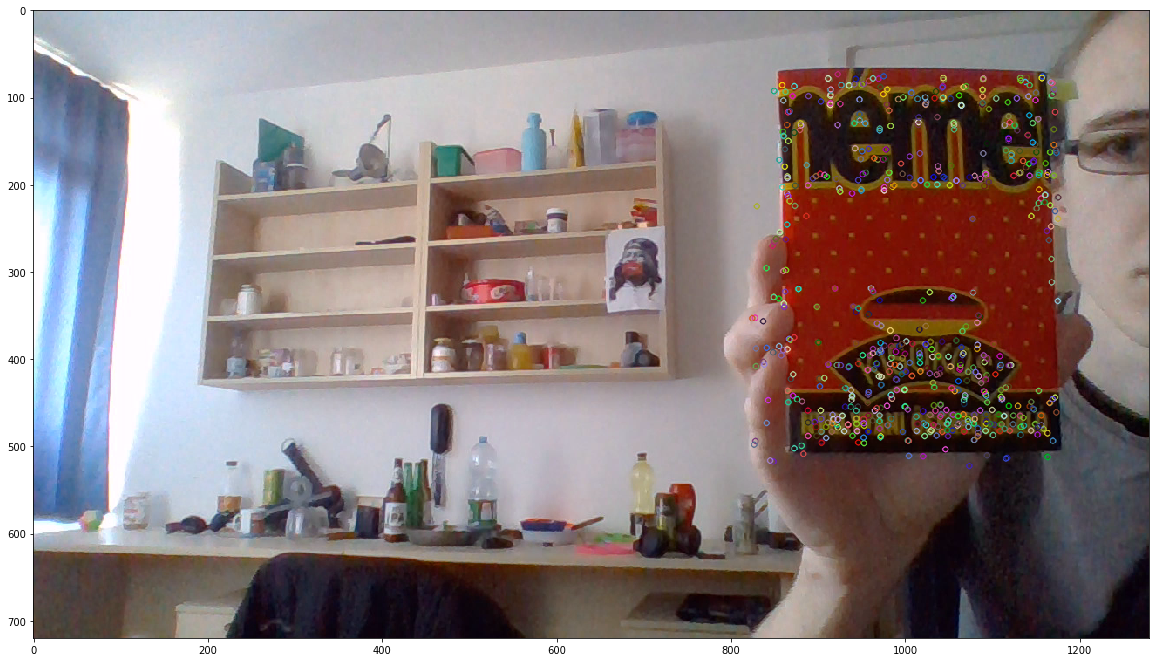

In [27]:
img_dir = "images/"
# r, h, c, w = 450, 100, 890, 100  # rubber
# r,h,c,w = 250,300,850,75 # election day bracelet
# r,h,c,w = 200,200,800,350 # blue
# r, h, c, w = 200, 400, 525, 300  # head
r, h, c, w = 75, 450, 825, 350  # head
track_window = (c, r, w, h)

cap = cv.VideoCapture(img_dir + "german.mp4")
_, first_frame = cap.read()
mask = np.zeros_like(first_frame)
mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
mask[r:r+h, c:c+w] = 1
_, org_pts, org_feat = feature_match(first_frame, resize=False, mask=mask)
cv.drawKeypoints(first_frame, org_pts, first_frame)
cv_show_pics(1,1, [first_frame])
# print(pts)

In [32]:
%%time
fourcc = cv.VideoWriter_fourcc(*'DIVX')
h, w, _ = first_frame.shape
out = cv.VideoWriter('output.mkv', fourcc, 25.0, (w, h), isColor=True)
while True:
    ret, frame = cap.read()

    if ret:
        # frame_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        # prob_map = cv.calcBackProject([frame_hsv], channels, roi_hist, ranges, 1)
        # ret, track_window = cv.meanShift(prob_map, track_window, term_crit)
        # ret, track_window = cv.CamShift(prob_map, track_window, term_crit)
        # x, y, w, h = track_window
        # frame = cv.rectangle(frame, (x, y), (x + w, y + h), 255, 10)
        # frame = draw_box(ret, frame)
        # frame = np.concatenate([frame, prob_map], axis=1)
        _, pts, feat = feature_match(frame, False)
        bf = cv2.DescriptorMatcher_create("BruteForce")
        matches = bf.knnMatch(org_feat, feat, k=2)
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append(m)
        matches = good
        MIN_MATCH_COUNT = 10
        if len(matches)>MIN_MATCH_COUNT:
            m_pts = np.float32([ pts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)
            org_m_pts = np.float32([ org_pts[m.queryIdx].pt for m in matches ]).reshape(-1, 1, 2)
            H, mask = cv2.findHomography(org_m_pts, m_pts, cv2.RANSAC, 5.0)
            matchesMask = mask.ravel().tolist()
            corner_points = np.array([[c,r,1],
                                      [c,r+h,1],
                                      [c+w,r+h,1],
                                      [c+w,r,1]
                                     ])
            t_c = H.dot(corner_points.T)
            cs = np.array([[int(c[0]/c[2]), int(c[1]/c[2])] for c in t_c.T])
            frame = cv.drawMatches(first_frame, org_pts, frame, pts, matchesMask, frame)
            cv_show_pics(frame)
            print(cs)
            break
        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None

        out.write(frame)
    else:
        break
out.release()

TypeError: Expected cv::DMatch for argument 'matches1to2'

In [8]:
cap.release()